### STARTING THE NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re


# clustering algorithms
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram
from sklearn.mixture import GaussianMixture
from spectralcluster import SpectralClusterer
from sklearn.metrics import davies_bouldin_score , silhouette_score , calinski_harabasz_score 
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.cluster import AgglomerativeClustering, OPTICS, cluster_optics_dbscan, Birch, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler , RobustScaler , StandardScaler


import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
#set seed for productivity of the project
SEED = 2021
def seed(SEED=SEED):
    import os
    np.random.seed = SEED
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
seed()



## TAST 1

### Generating artificial Dataset to test clustering methods

In [3]:

# generate 500 datapoints using make blob function
from sklearn.datasets import make_blobs
X_data , y_labels = make_blobs(
    n_samples=500,
    centers=3,
    cluster_std=2.75,
    random_state=SEED
)

In [4]:
# scale the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_data)

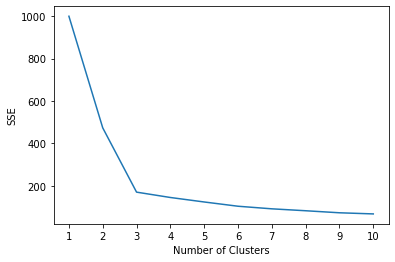

In [5]:
# determine the best k value using kmeans

# model params
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    
# plot the elbow curve
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### From the results it is observed 3 is the best value for cluster
- We are going to use 3 as optimum clusters numbers

In [6]:
scaled_features.shape

(500, 2)

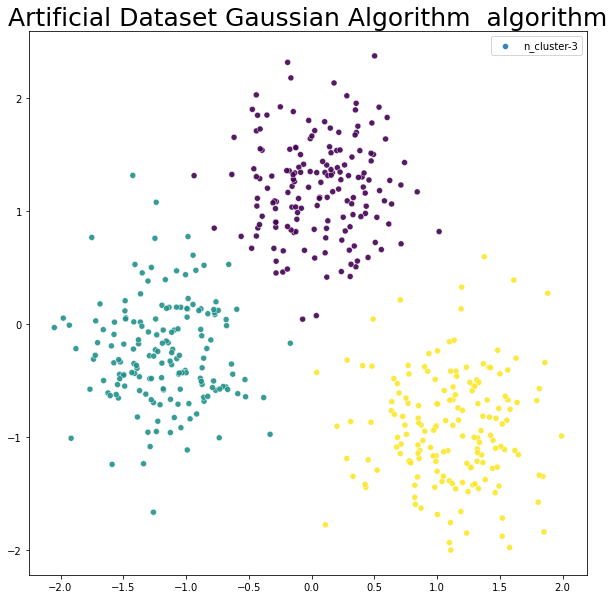

In [7]:
gausian_model = GaussianMixture(n_components=3, random_state=2021, n_init=5)
gausian_model.fit(scaled_features)
cluster_labels_artificial = gausian_model.predict(scaled_features)
plt.figure(figsize=(10 , 10))
sns.scatterplot(scaled_features[:, 0], scaled_features[:, 1] , c = cluster_labels_artificial , alpha=0.9 , label="n_cluster-"+str(len(set(cluster_labels_artificial))))
plt.title("Artificial Dataset Gaussian Algorithm  algorithm" , fontsize =25)
plt.show()

In [8]:
from sklearn.metrics import accuracy_score

print(f"THE MODEL WAS ABLE TO CLASSIFY {accuracy_score(y_labels, cluster_labels_artificial)} of the data to their correct clusters")

THE MODEL WAS ABLE TO CLASSIFY 0.992 of the data to their correct clusters


### We see the the model has found correct clusters for 99% of the datapoints

# TASK 2 

## WORKING ON THE REAL WORLD DATASET
- In this part were are going to investigate various clustering algorithms on a real dataset
- The dataset was download from UCI Machine Learning Repository
- Here is the link to access the dataset https://archive.ics.uci.edu/ml/datasets/Travel+Reviews
- It is Reviews on destinations in 10 categories mentioned across East Asia. 
- Each traveler rating is mapped as Excellent(4), Very Good(3), Average(2), Poor(1), and Terrible(0) and average rating is used.
- It has 11 attributes where 10 are review categories and 1 is the user ID who was the reviewer


In [9]:
# read the dataset
df = pd.read_csv("tripadvisor_review.csv")

In [10]:
# check the number of features in the dataset
df.shape

(980, 11)

In [11]:
# preview the dataset
df.head()

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [12]:
# remove the User ID since it is not required in this case
df.drop(['User ID'] , axis =1 , inplace = True)

In [13]:
df.head()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [14]:
# check sample
df.tail(10)

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
970,0.58,1.96,0.24,0.47,1.04,1.74,3.18,2.70,1.57,2.62
971,1.28,1.24,0.14,0.55,0.62,2.26,3.18,2.86,2.46,2.54
972,1.22,1.16,0.38,1.55,0.40,1.24,3.18,2.82,1.92,2.54
973,0.38,1.96,0.19,0.48,1.14,2.14,3.18,2.78,1.54,2.58
974,1.02,2.44,1.89,0.47,1.76,2.50,3.19,2.66,1.73,2.48
975,0.74,1.12,0.30,0.53,0.88,1.38,3.17,2.78,0.99,3.20
976,1.25,0.92,1.12,0.38,0.78,1.68,3.18,2.79,1.34,2.80
977,0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02
978,0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46
979,0.93,0.56,1.13,0.51,1.34,2.36,3.18,2.87,1.34,2.40


<AxesSubplot:xlabel='Category 10', ylabel='Density'>

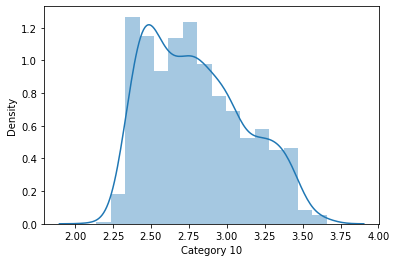

In [15]:
# check distribution of a random column
sns.distplot(df['Category 10'])

- Since some columns seems to have abnormal distribution i.e data is skewed to one side.
- We are going to use normalization to where it will be scalled using minimax algorithm (between 1 and 0)


- Lets first check how many components can give a good description of the whole dimention
- PCA will be used to turn all columns to a component dimension
- It will create 11 components which are same as the number of columns available

In [16]:
# in order to work well , try reducing the dimension of the data points
# Apply PCA by fitting the data with the same number of dimensions as features
n_components = df.shape[1]
pca = PCA(n_components=n_components, random_state=SEED)
pca.fit(df)

#transform the df using the PCA fit above
pca_df = pca.transform(df)

- Checking the representation of each componet of the whole dataset
- We will use explained variance ration

In [17]:
# get variance/data representability of each of the component
for i in range(n_components):
    first_n = pca.explained_variance_ratio_[0:i+1].sum()*100
    print(f'Percent variance explained by first {i+1} components: {round(first_n , 4)}%')


Percent variance explained by first 1 components: 42.5201%
Percent variance explained by first 2 components: 60.2432%
Percent variance explained by first 3 components: 72.6965%
Percent variance explained by first 4 components: 80.0151%
Percent variance explained by first 5 components: 86.9498%
Percent variance explained by first 6 components: 92.3299%
Percent variance explained by first 7 components: 96.4596%
Percent variance explained by first 8 components: 99.0469%
Percent variance explained by first 9 components: 99.9992%
Percent variance explained by first 10 components: 100.0%


### Observation

- We can see that the majority of the variance in our data (>95%) can be encoded in 7 of our 10 dimensions. We see that over 72% of our variance can be encoded in 3 dimensions. This suggests that we can expect to see some of the underlying structure in a 3D visualization although some information willbe hidden

- Also at 2D 60% of the information can be encodeded , we can be able to gather much information using the first 2 components
- While we will use all 10 metrics in our clustering algorithm, we will first map our our data to 2 dimensions using PCA and visualize. 
- We will return to this compressed dataset after assigning labels to all of our records to visualize the results of our clustering efforts.

In [18]:
mms = MinMaxScaler()
mms.fit(df)
df = mms.transform(df)


pca = PCA(n_components=2, random_state=SEED)
pca.fit(df)

#transform wines_norm using the PCA fit above
traindf = pca.transform(df)

In [19]:
traindf.shape

(980, 2)

<AxesSubplot:title={'center':'2D plot of the data representation'}>

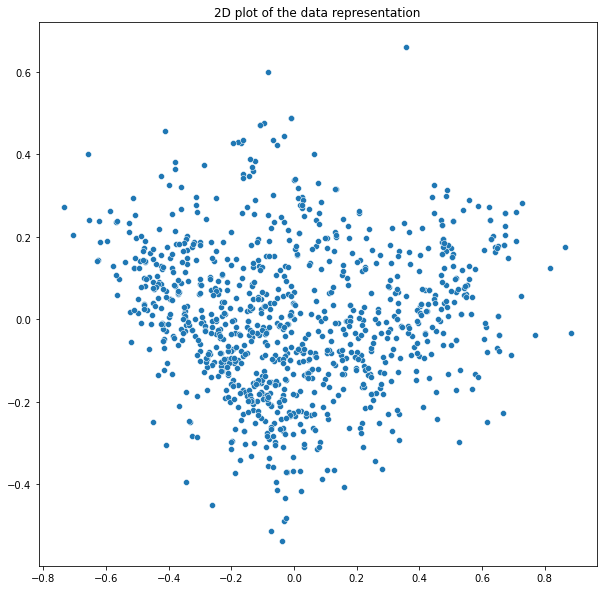

In [20]:
plt.figure(figsize=(10 ,10))
plt.title("2D plot of the data representation")
sns.scatterplot(traindf[: , 0] , traindf[: , 1])

#### Observation
- From the above plot there seems no distinguishable pattern for groups
- Some algorithms for clustering will be used to perfom check for distinguishable pattern for groups


An analytic method will be used to determine the best number of groups

This analytical will be done as follows:

1) We will fit our clustering algorithm using several different values of k where k is the number of clusters. We will have k range from 2 to 15.

2) For each value of k, we will evaluate the clustering results using the average Sum of squared distance score. We will plot the results against each k value and identify which number of clusters leads to the best results. This method is called ELBOW CURVE method

3) Clusters will then be assigned to the required data point

4) Silhoutte score will also be used just to check for the best value. For this method , Gaussian method will be used while for elbow curve , KMEANS will be used
- In order to check how each cluster perfomed , we will use sillhouette score.



The sillhouette score is described as a measure of how close a sample is to members of its own cluster as compared to members of other clusters. The silhoette score ranges from -1 to 1. A score close to one indicates that a record is very close to other members of its cluster and far from members of other clusters. A score of 0 indicates that a record lies on the decision boundary between two clusters. A negative score indicates that a sample is closer to members of a cluster other than its own. By taking the average silhouette score for all records when various number of clusters are used in our clustering algorithm, we can find the optimal number of clusters that promotes cohesion within individual clusters and good seperability between the clusters.

For the clustering algorithm  some algorithms will be selected but  Gaussian Mixture Model was chosen to identify the optimum clusters. 
This was selected due to the fact that gaussian mixture models allow for mixed membership; GMM models assign probabilities that a given record belongs to a given cluster. This property may be useful for mapping each travellors rating.

#### Elbow curve method

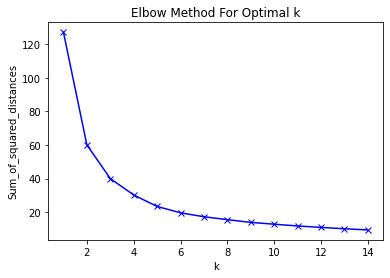

In [21]:
# Not knowing the number of clusters (3) we try a range such 1,10
# For the ELBOW method check with and without init='k-means++'

Sum_of_squared_distances = []
for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++')
    km = km.fit(traindf)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(range(1,15), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### SIlhoutte score method

In [22]:
max_k=15

sil_scores=[]
for i in range(2, max_k+1):
    clusterer = GaussianMixture(n_components=i, random_state=SEED, n_init=5)
    clusterer.fit(traindf)

    #Predict the cluster for each data point
    preds = clusterer.predict(traindf)

    #Find the cluster centers
    centers = clusterer.means_

    #Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(traindf, preds)
    sil_scores.append(score)
    
sil_scores= pd.Series(sil_scores, index= range(2,max_k+1))
max_score= sil_scores.max()
n_clusters= sil_scores.idxmax()
print('Max Silhouette Score: {:.3f}'.format(max_score))
print('Number of clusters: {}\n'.format(max_k))

print('First 3 Silhouette Scores')
print(sil_scores[0:3])


Max Silhouette Score: 0.463
Number of clusters: 15

First 3 Silhouette Scores
2    0.462561
3    0.388971
4    0.413012
dtype: float64


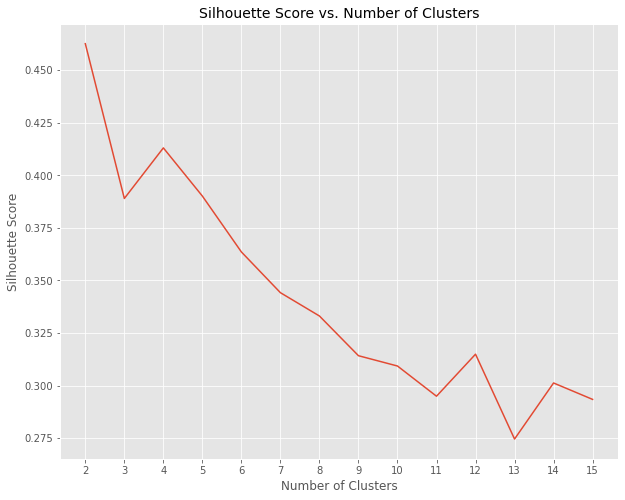

In [23]:
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.title('Silhouette Score vs. Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(2, max_k+1, 1))
plt.plot(sil_scores.index.values, sil_scores)

### Observation
- We see that the silhouette score is maximized when 2 clusters are used. Therefore, we fit the GMM using 2 clusters. We will now color each of our clusters and visualized the data in 3 dimensions again. We will append results to see how this property is distributed among our clusters.
- For elbow curve method, the values seems to be ranging from 2 to 4
- Elbow and Silhoute methods have no much great different hence we choose to generalize between 2 and 5 as our preffered cluster numbers



- From the above we are going to use k as 2 , 3 , 4 since they seems to be better

### Analysis of different cluster numbers using different algorithms

- We are going some of the best algorithms for clustering to try see how many distint groups are there

#### 1. Gaussian Mixture Algorithm

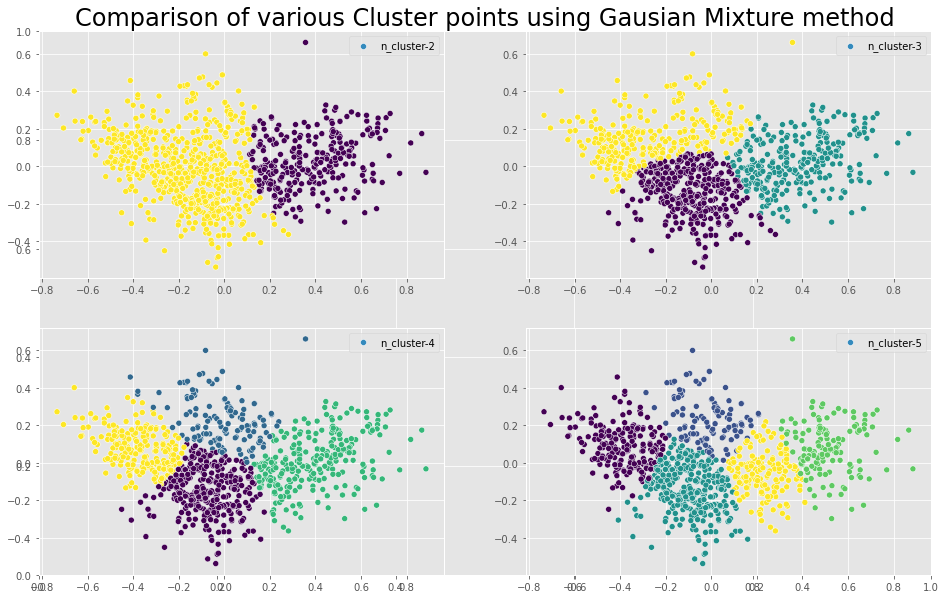

In [24]:
f = plt.figure(figsize=(16 ,10))
plt.title("Comparison of various Cluster points using Gausian Mixture method" , fontsize =24)
f.add_subplot(2, 2, 1)
for i in [2,3,4 , 5]:
    model_i = GaussianMixture(n_components=i, random_state=2021, n_init=5)
    model_i.fit(traindf)
    label_i = model_i.predict(traindf)
    f.add_subplot(2, 2, i-1)
    sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = label_i , label="n_cluster-"+str(i))
    plt.legend()
plt.show()

### Observation 
- Using this method , the best number of clusters seems to be cluster 3 and cluster 4

#### 2. SpectralClustering algorithm

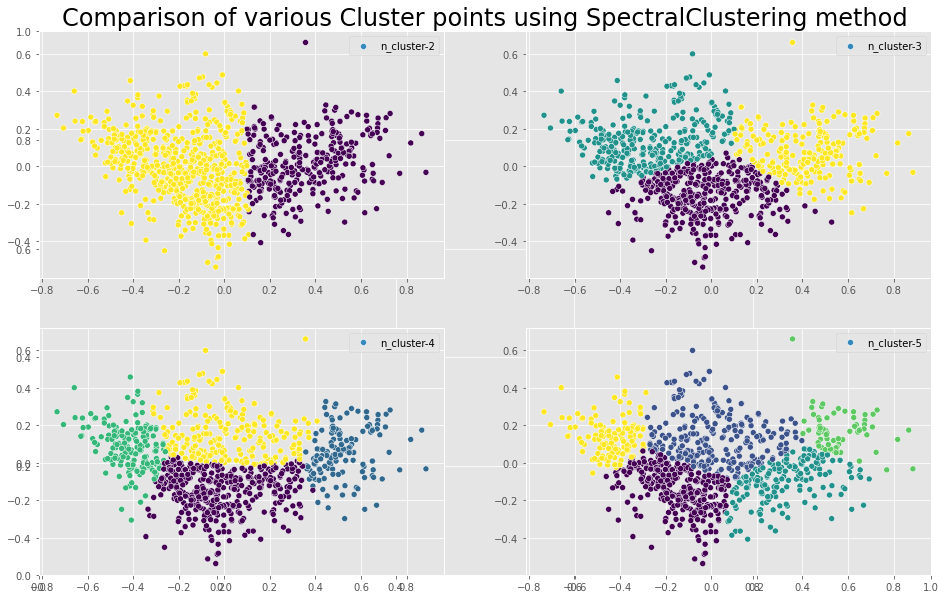

In [25]:
f = plt.figure(figsize=(16,10))
plt.title("Comparison of various Cluster points using SpectralClustering method" , fontsize =24)
f.add_subplot(2, 2, 1)
for i in [2,3,4 , 5]:
    sc = SpectralClustering(n_clusters=i)
    sc.fit(traindf)
    f.add_subplot(2, 2, i-1)
    sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = sc.labels_ , label="n_cluster-"+str(i))
    plt.legend()
plt.show()

#### Observation 
- This SpectralClustering method perfoms very well it is able to create a distinguishable groups in all clusters
- Most specifically clusters 3 , 4 and 5

### 3. SpectralClusterer

- This algorithm will select its own cluster points

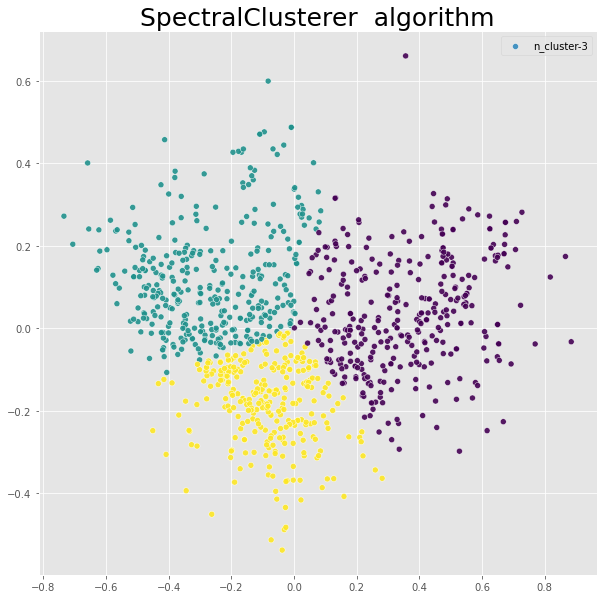

In [26]:
clusterer_model = SpectralClusterer(min_clusters=2,max_clusters=5)

cluster_labels = clusterer_model.predict(traindf)
plt.figure(figsize=(10 , 10))
sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = cluster_labels , alpha=0.9 , label="n_cluster-"+str(len(set(cluster_labels))))
plt.title("SpectralClusterer  algorithm" , fontsize =25)
plt.show()

- SpectralClusterer select its optimum number of clusters
- For this algorithm using clusters from 2 to 5
- It automatically selected 3 as its number of clusters
- The data points for each clusters are also distinguishable

#### 4. AgglomerativeClustering Algorithm method

- For this method in order to determing the optimal number of clusters , we will create a dendogram that will help us to create
- We are going to use only few number of levels for this dendogram.
- Only level 4 and 5 are going to be tested

In [27]:
# using hierachical aggro
def dendrogramPlot(model, **kwargs): 
    '''
    IT creates a dendogram plot using Agglomerative Clustering algorithm
    '''
    counts = np.zeros(model.children_.shape[0])

    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)  

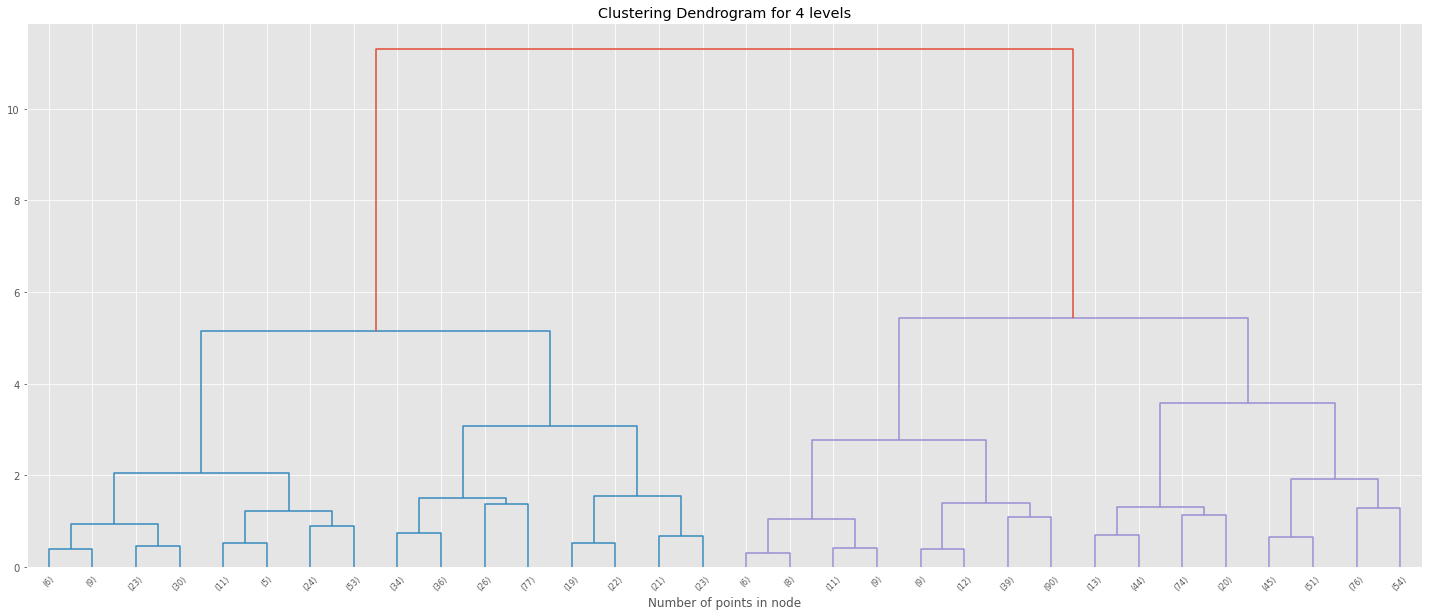

In [28]:
ClusteringModel = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# setting distance_threshold=0 ensures we compute the full tree.

ClusteringModel = ClusteringModel.fit(traindf)
plt.figure(figsize=(25,10))
plt.title('Clustering Dendrogram for 4 levels')
dendrogramPlot(ClusteringModel, p=4, truncate_mode='level')                    
plt.xlabel("Number of points in node")
plt.show()


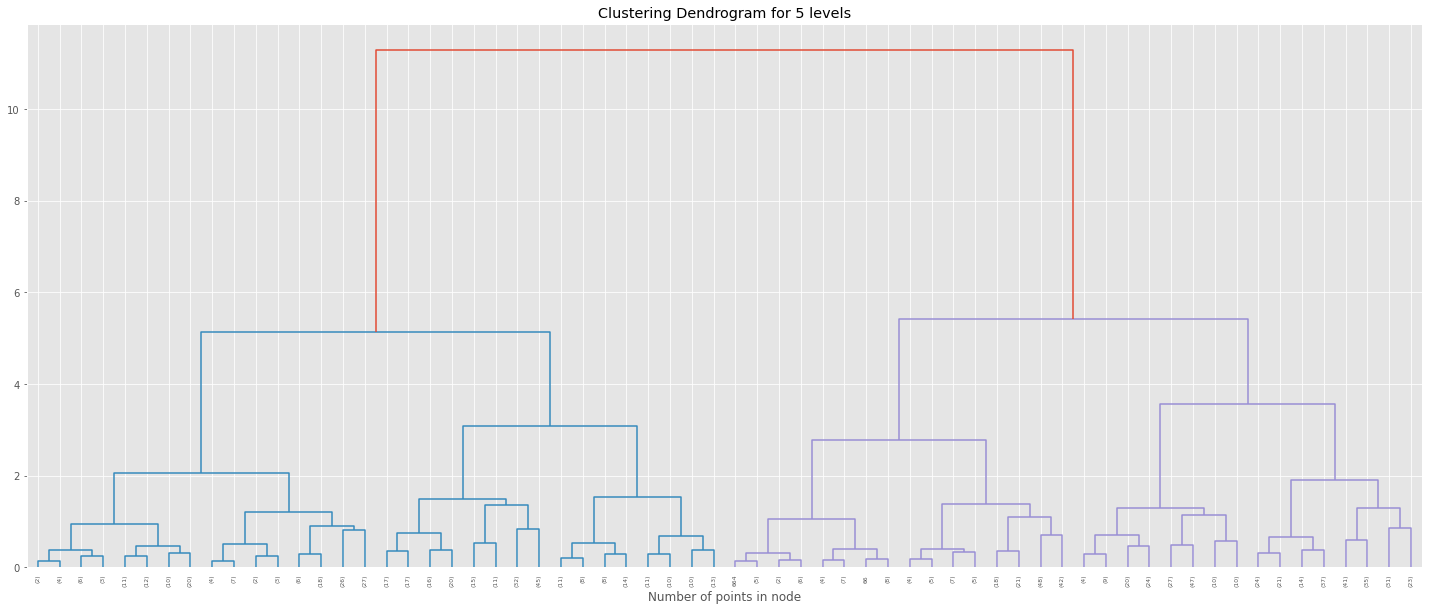

In [29]:
plt.figure(figsize=(25,10))
plt.title('Clustering Dendrogram for 5 levels')
dendrogramPlot(ClusteringModel, p=5, truncate_mode='level')                    
plt.xlabel("Number of points in node")
plt.show()

### Obsservation 
- Based on the above dendograms  plot , they suggest that the best number of clusters to be 4 from both 2
- This is used based on  Hierarchical Agglomerative Clustering Algorithm
- We are going to plot a graph of the classes label predicted using the model

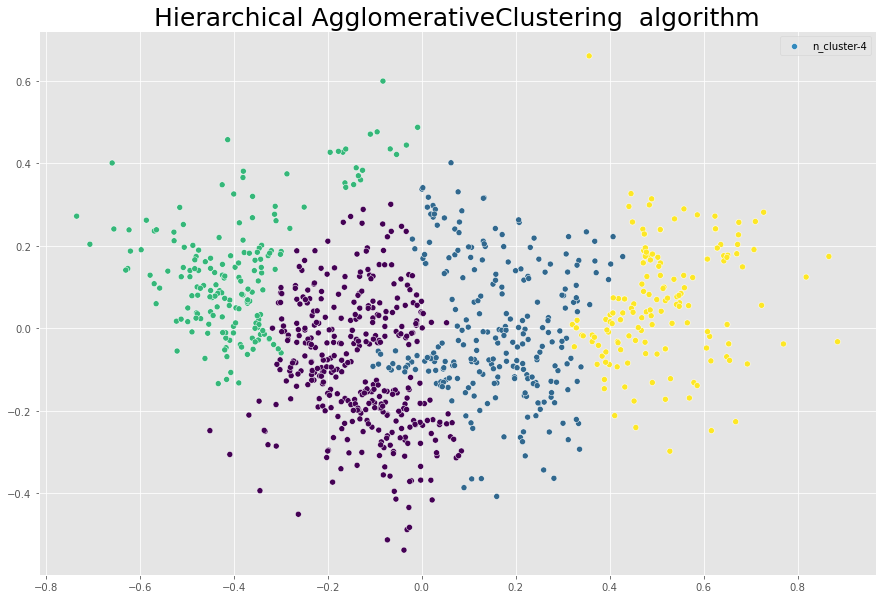

In [30]:
model_agglo = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model_agglo.fit(traindf)
labels_agglo = model_agglo.labels_

# plot
plt.figure(figsize=(15 , 10))
sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = labels_agglo , label="n_cluster-"+str(len(set(labels_agglo))))
plt.title("Hierarchical AgglomerativeClustering  algorithm" , fontsize =25)
plt.show()

#### 5. DBSCAN algorithm

In [31]:
# create the dbscan model
db = DBSCAN(eps = 0.095, min_samples = 20).fit(traindf)
labels1 = db.labels_

# check the number of unique values predicted
np.unique(labels1)

array([-1,  0])

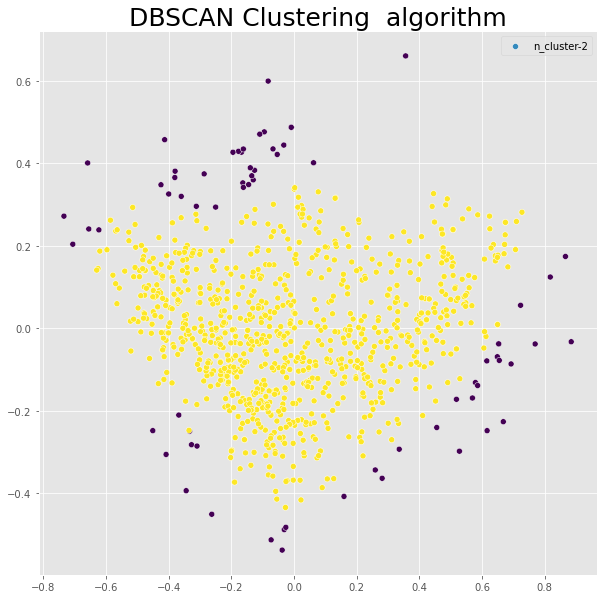

In [32]:
# plot
plt.figure(figsize=(10 , 10))
sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = labels1 , label="n_cluster-"+str(len(set(labels1))))
plt.title("DBSCAN Clustering  algorithm" , fontsize =25)
plt.show()

### Observation

- The model does not predict well.
- It has just grouped into two clusters which appears not to be well distinguishable

### 6. Different KMEANS METHODS and different distance methods

In [33]:
#step size of the mesh

#a point in mesh
h = 0.015 
# for plotting decision boundary . each will have its won color.
x_min, x_max = traindf[:, 0].min() - 1, traindf[:, 0].max() + 1
y_min, y_max = traindf[:, 1].min() - 1, traindf[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

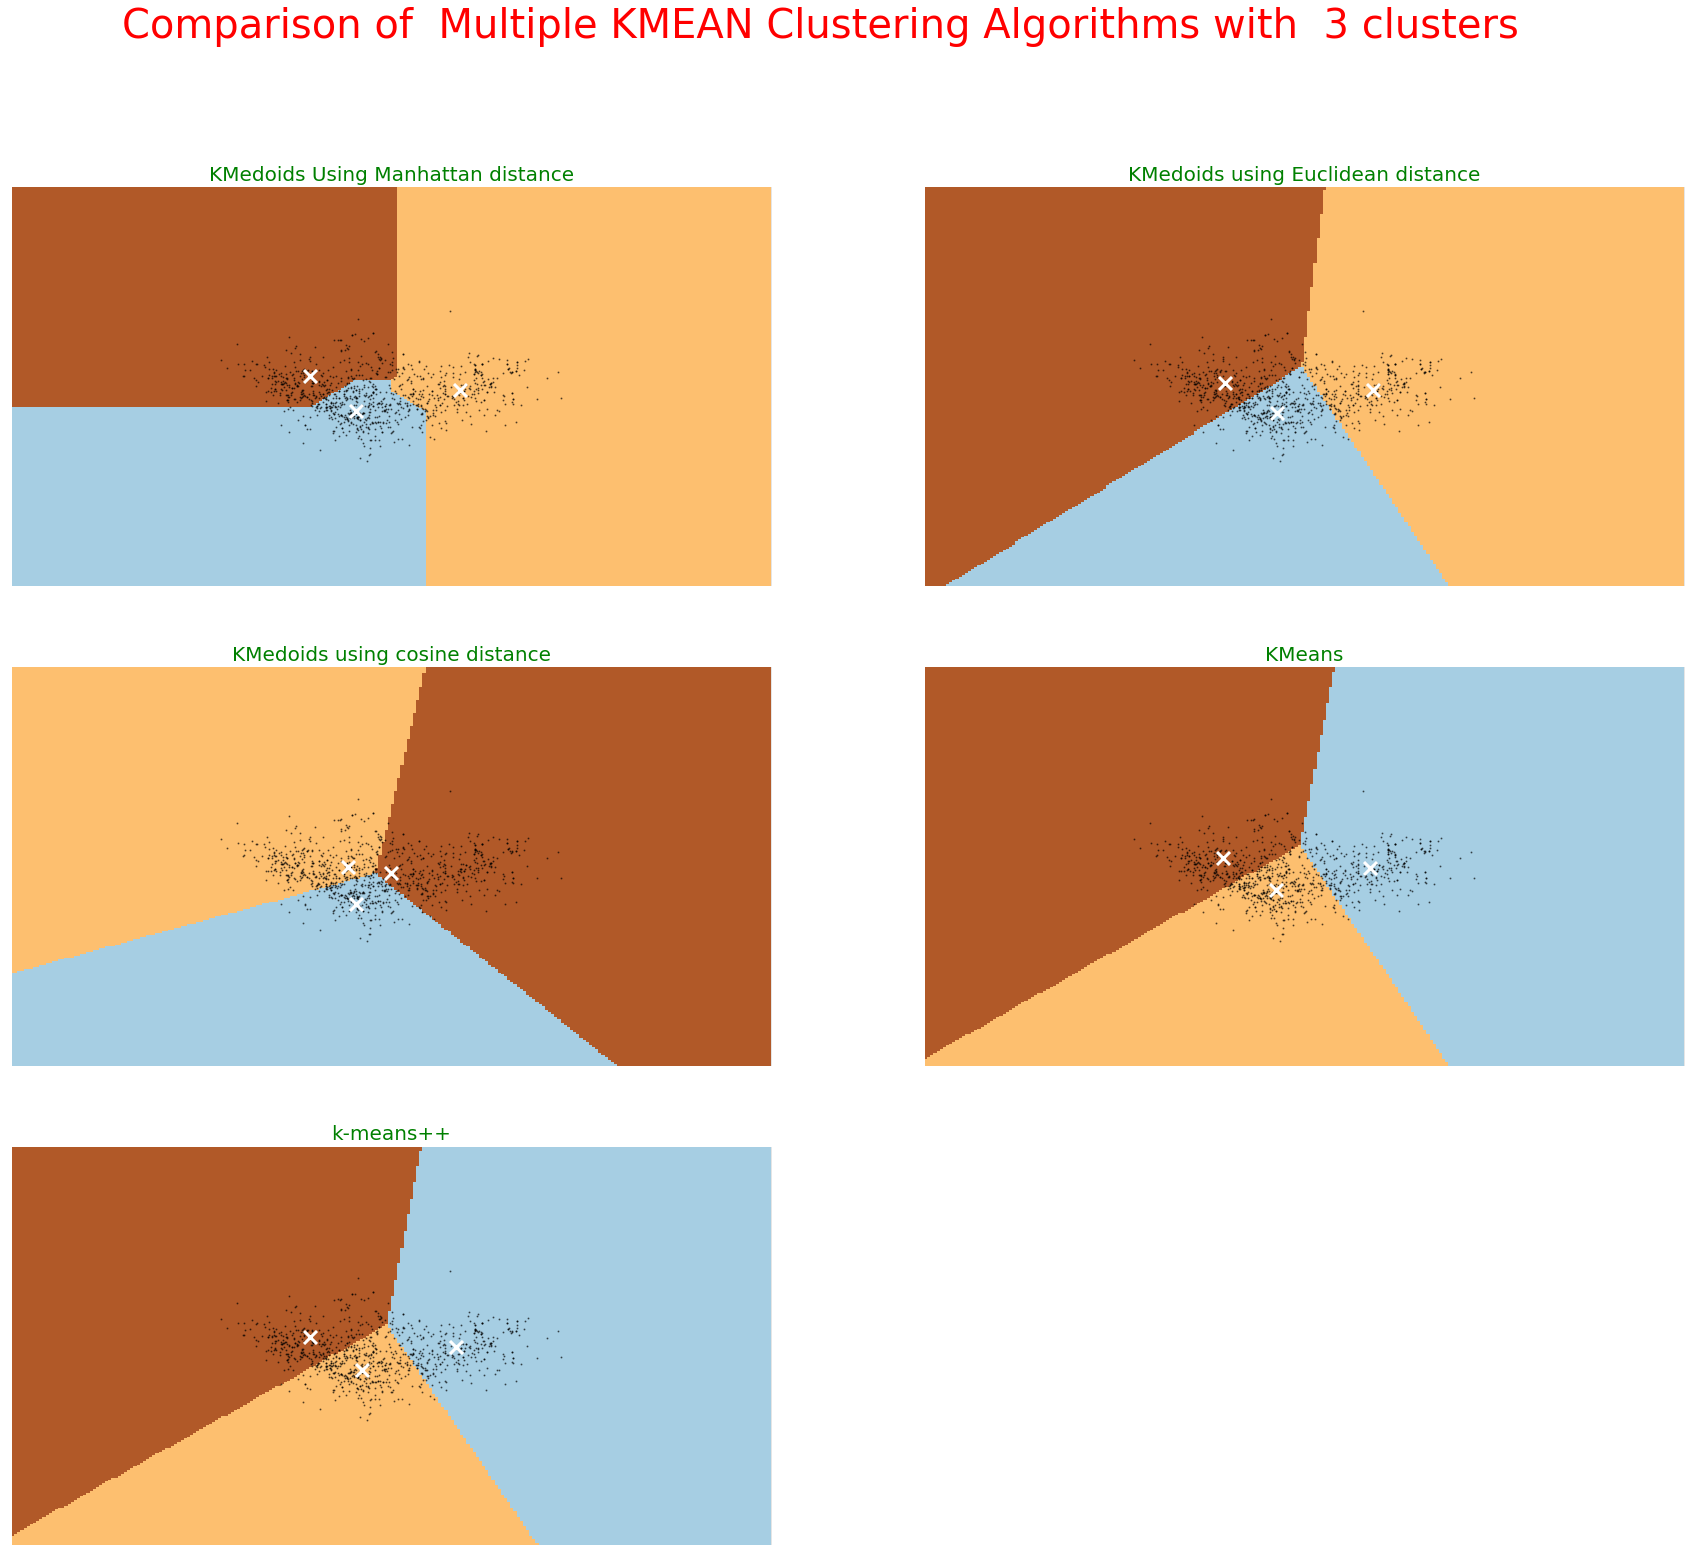

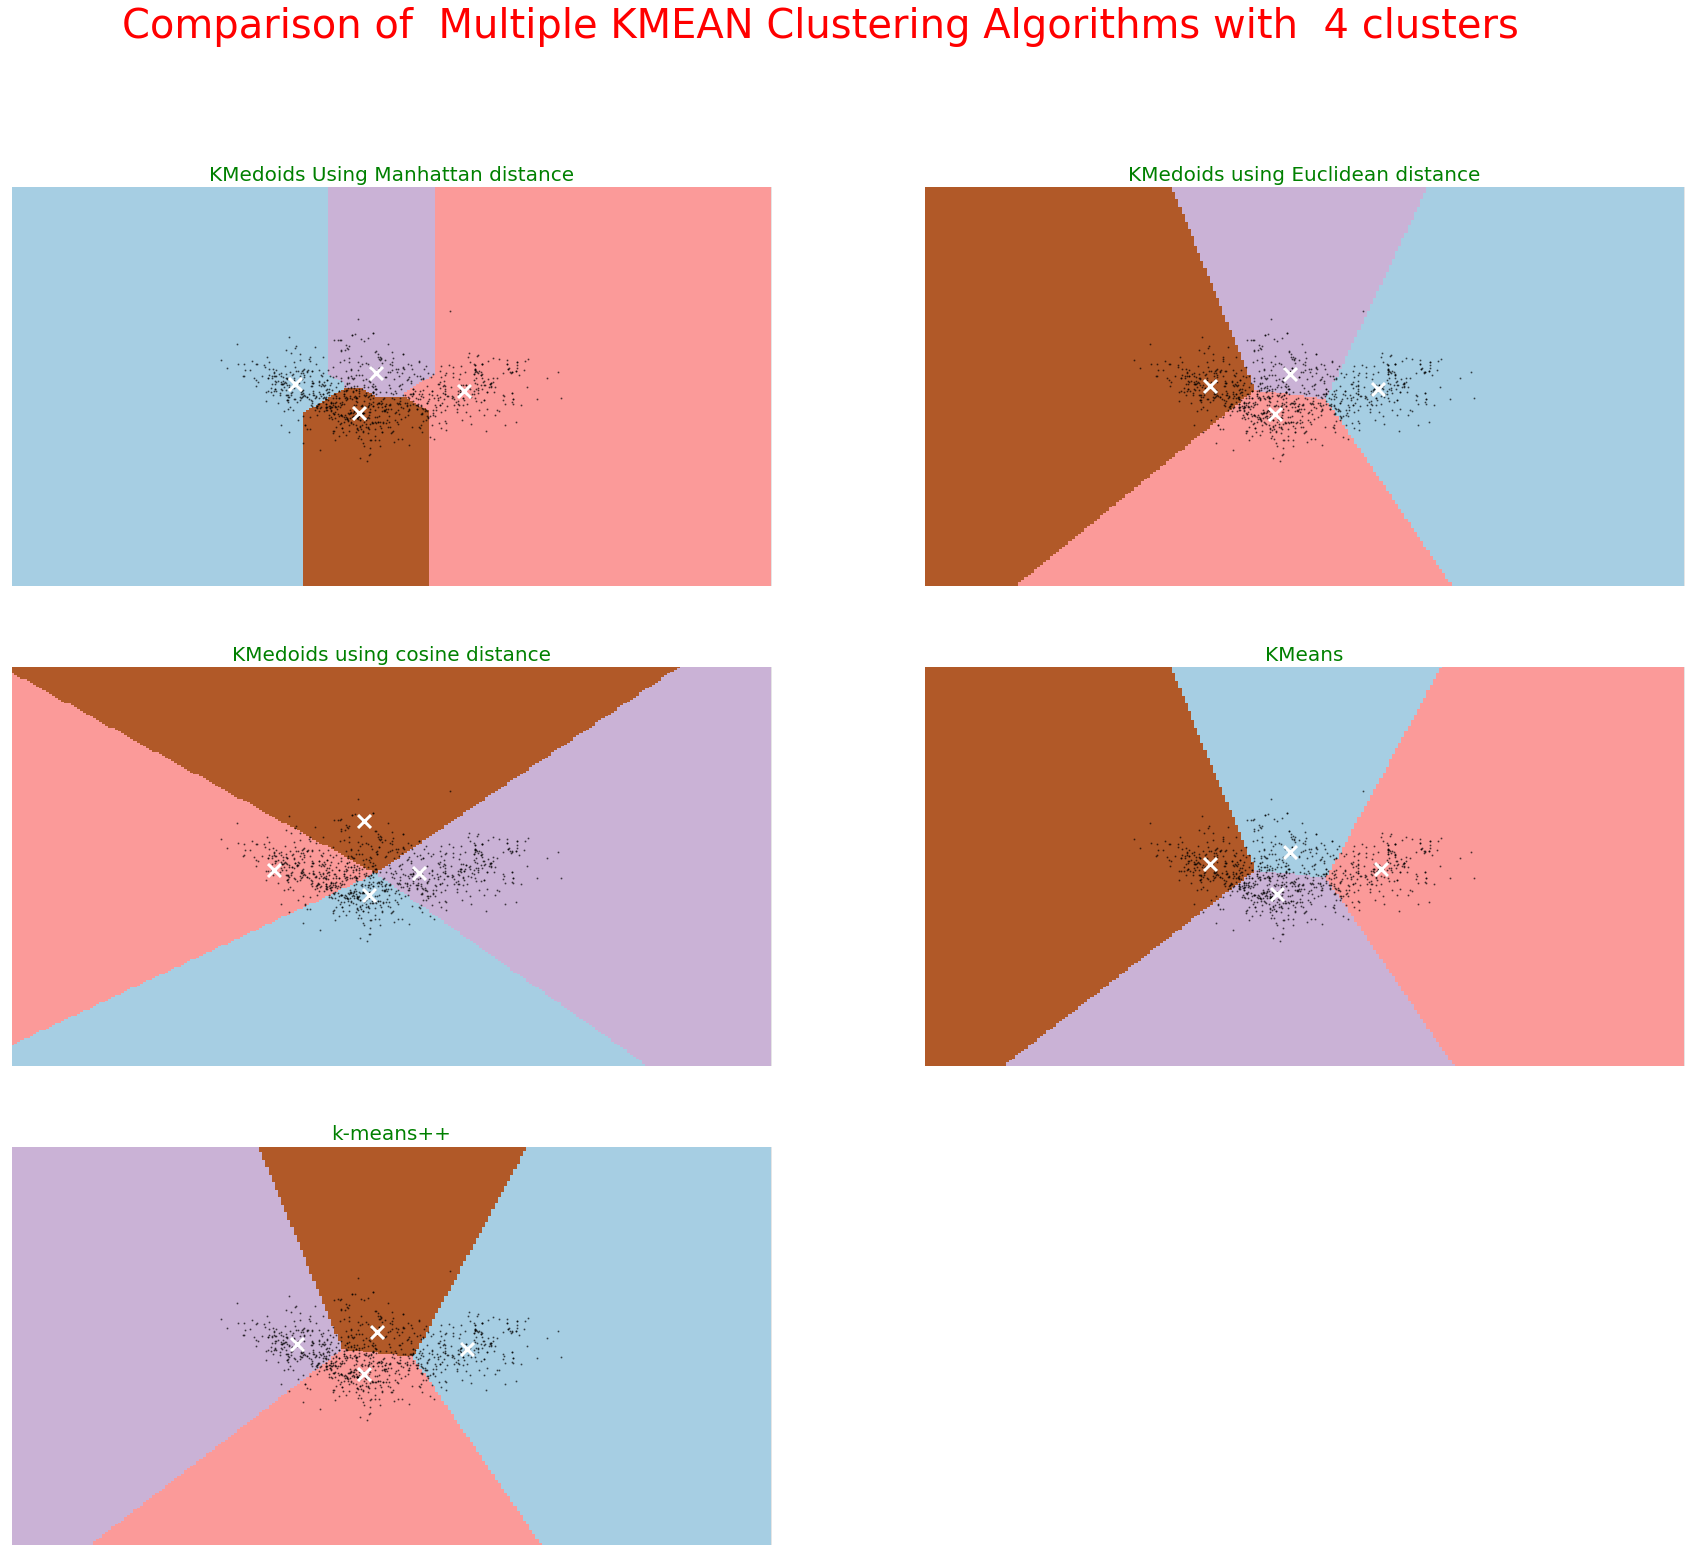

In [34]:
"""
THree distances methods are going to be used in KMeans (KMedoids)
They include the following
    - Manhattan
    - Cosine
    - Euclidean
"""
for n_points in [3 ,4]:
    n_rows = 2
    n_cols = 3
    plt.figure(figsize=(30,25))
    plt.suptitle(f"Comparison of  Multiple KMEAN Clustering Algorithms with  {n_points} clusters",fontsize=40,color='r')

    selected_models = [
        (KMedoids(metric="manhattan", n_clusters=n_points),"KMedoids Using Manhattan distance",),
        (KMedoids(metric="euclidean", n_clusters=n_points),"KMedoids using Euclidean distance",),
        (KMedoids(metric="cosine", n_clusters=n_points), "KMedoids using cosine distance"),
        (KMeans(n_clusters=n_points), "KMeans"),
        (KMeans(n_clusters=n_points, init='k-means++'),"k-means++")
    ]

    for i, (select_model, description) in enumerate(selected_models):
        select_model.fit(traindf)
        y = select_model.predict(np.c_[xx.ravel(), yy.ravel()])
        y = y.reshape(xx.shape)
        #plot the cluster results
        plt.subplot(n_cols, n_rows, i + 1)
        plt.imshow(y, interpolation="nearest", 
                   extent=(xx.min(), xx.max(), 
                   yy.min(), yy.max()),
                   cmap=plt.cm.Paired, 
                   aspect="auto", origin="lower",
                  )
        plt.plot(traindf[:, 0], traindf[:, 1], "k.", markersize=2, alpha=0.5)


        centroids = select_model.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3, color="w", zorder=10,)
                                            # set centroids shape as a X        ; set centroids color as a white
        plt.title(description , fontsize=20 , color='g')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
    plt.show()

### Observation

- Each algorithm has different distingishable features
- Cluster 3 seems to be well separated in all algorithm
- Kmeod algorithm using cosine distance had the best graph using 4 clusters

### 7.  Birch Algorithm

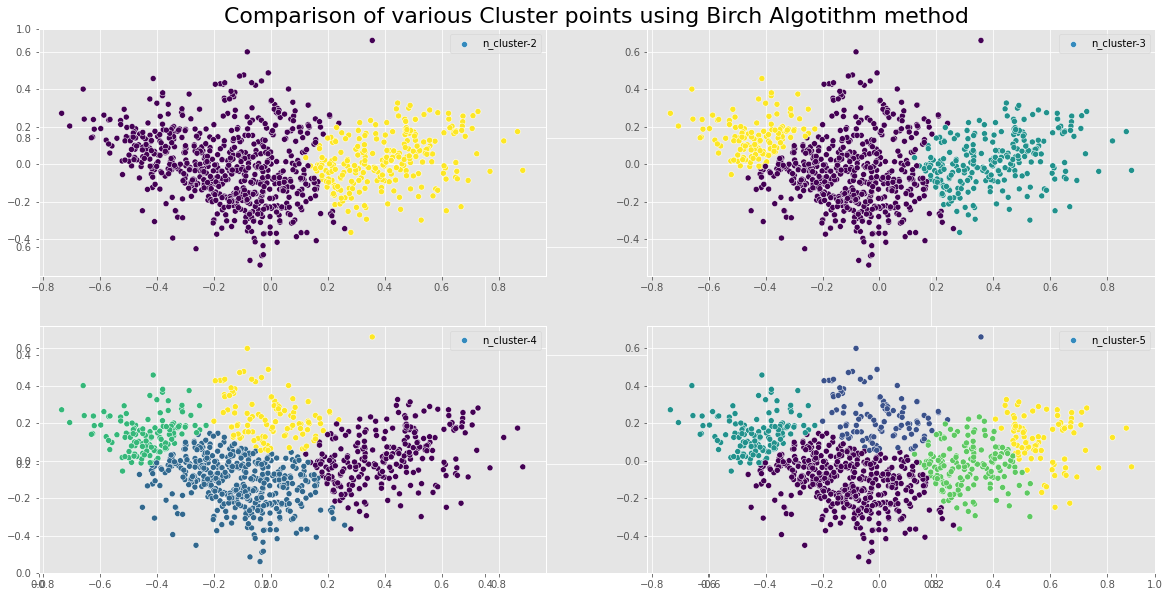

In [35]:
# using birch clustering
f = plt.figure(figsize=(20 ,10))
plt.title("Comparison of various Cluster points using Birch Algotithm method" , fontsize =22)
f.add_subplot(2, 2, 1)
for i in [2,3,4 , 5]:
    brc = Birch(n_clusters=i , threshold=0.2)
    brc.fit(traindf)
    label_brc = brc.predict(traindf)
    f.add_subplot(2, 2, i-1)
    sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = label_brc , label="n_cluster-"+str(i))
    plt.legend()
plt.show()

In [36]:
# np.unique(Birch(n_clusters=4 , branching_factor=50 , threshold=0.2).fit_predict(traindf))

- Cluster 2 and 5 seems to be distinguished very well using this algorithm
- In cluster 3 there seems to have a group that is not separated well

#### 8. MIniBatchKmeans algorithm

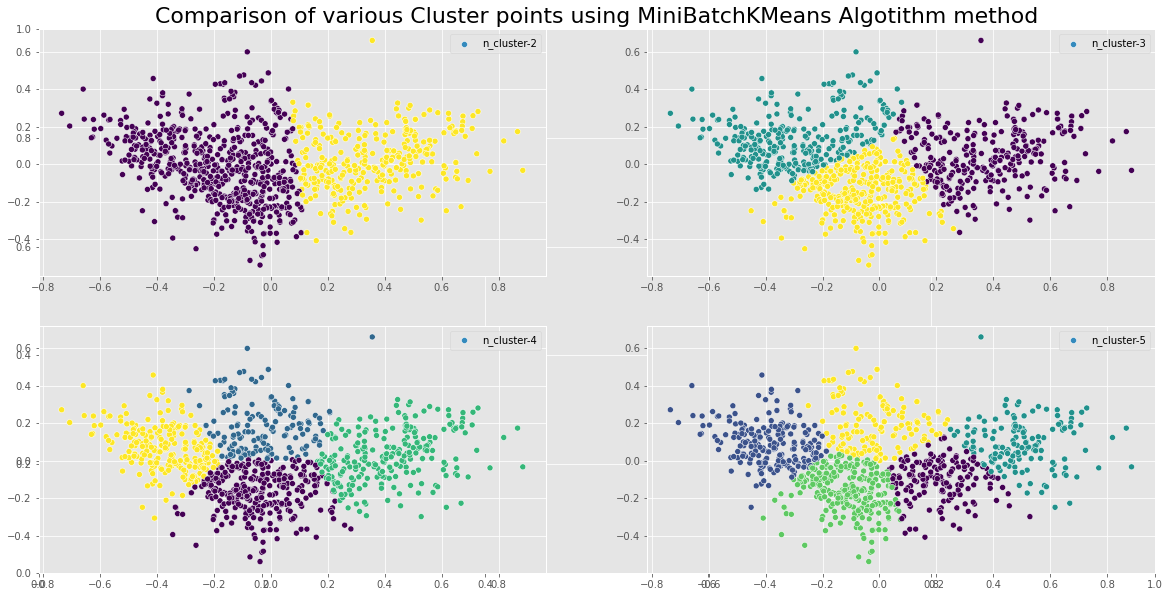

In [37]:
# using birch clustering
f = plt.figure(figsize=(20 ,10))
plt.title("Comparison of various Cluster points using MiniBatchKMeans Algotithm method" , fontsize =22)
f.add_subplot(2, 2, 1)
for i in [2,3,4 , 5]:
    minibatch = MiniBatchKMeans(n_clusters=i , batch_size=16 , random_state=2021)
    minibatch.fit(traindf)
    label_batch = minibatch.predict(traindf)
    f.add_subplot(2, 2, i-1)
    sns.scatterplot(traindf[:, 0], traindf[:, 1] , c = label_batch , label="n_cluster-"+str(i))
    plt.legend()
plt.show()

### Observation

- This model perfomed well in all clusters
- All clusters data points are well distinguishable most specifically to cluster 3

- SInce a quite good number of clustering algorithms have been tested , silhouette_score and davis score are going to be used for comparison which is better
- The algorithms will be trained on both cluster 3 and 4 since most of algorithms optimimly perfomed in here.
- The following algorithms will be tested.
    - Kmeans(kmean+++)
    - Spiral clustering
    - Gaussian
    - Minibatch kmeans
    - spiral clustering
    - clusterer
    - Kmeod
    - AgglomerativeClustering
    
- In order to compaire these models  Davies-Bouldin score and  silhouette_score are used as methods for measuring
- For silhoute score , the greater the value the bestter the clustering algorithm while for Davies-Bouldin , the lesser the score the better the clustering

In [38]:
def find_clusters_scores(n_clusters , data):
    """
    Runs the models with the number of clusters passed.. 
    Returns silhouette score and davis score
    """
    scores_davis = []
    scores_silhoute = []
    
    gausian = GaussianMixture(n_components=n_clusters, random_state=SEED, n_init=5)
    minibatch = MiniBatchKMeans(n_clusters=n_clusters , batch_size=16 , random_state=2021)
    model_agglo = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    clusterer_model = SpectralClusterer(min_clusters=n_clusters,max_clusters=5)
    spectarol = SpectralClustering(n_clusters=n_clusters)
    kmeod = KMedoids(metric="cosine", n_clusters=n_clusters)
    kmean = KMeans(n_clusters=n_clusters, init='k-means++')
    
    all_models = [gausian , minibatch , model_agglo , clusterer_model ,spectarol , kmeod , kmean]
    models_names = [
        "Gaussian_mixture" , "MinibatchKmeans"  , "AgglomerativeClustering" ,
        "SpectralClusterer" , "SpectralClustering" , "KMedoids_cosine" , "Kmeans++"]
    for num , each_model in enumerate(all_models):
        
        if models_names[num] != "SpectralClusterer":
            each_model.fit(data)
            #get the scores and append to there lists'
            try:
                model_labels = each_model.labels_
            except Exception as e:
                model_labels = each_model.predict(data)
        else:
            model_labels = each_model.predict(traindf)
        scores_davis.append(davies_bouldin_score(data , model_labels))
        scores_silhoute.append(silhouette_score(data , model_labels))
        
    return models_names , scores_davis , scores_silhoute
    
    
    

In [39]:
# run the models with a clustring of 3 and 4

In [40]:
results_clusters3 = find_clusters_scores(3 , traindf)
results_clusters4 = find_clusters_scores(4 , traindf)

In [41]:
# dataframe for cluster 3 results
cl3 = pd.DataFrame(results_clusters3[1:] , columns= results_clusters3[:1][0] , index =["Davis Score" , "Silhoute Score"]).T

# dataframe for cluster 4 results
cl4 = pd.DataFrame(results_clusters4[1:] , columns= results_clusters4[:1][0] , index =["Davis Score" , "Silhoute Score"]).T

In [42]:
# sort it in descending order
cl3.sort_values("Silhoute Score" , ascending=0)

,Davis Score,Silhoute Score
MinibatchKmeans,0.883340,0.396502
Kmeans++,0.888266,0.396317
Gaussian_mixture,0.952638,0.388971
SpectralClustering,0.909897,0.378901
SpectralClusterer,0.879011,0.377372
KMedoids_cosine,0.848656,0.366039
AgglomerativeClustering,0.938955,0.336498


### Observation
- MiniBatchKmeans was the best perfoming algorithm when based with the silhoute score followed by kmeans and then Gaussian mixture.
- When Davies bouldin index score is used KMedoids with cosine similarity distance is the best .
- This cluster seems to be having different results of which model is the best .
- For this purpose <b color='red'>MinibatchKmeans and Kmeans++ </b> will be selected as the best model since they were first and second respectively when using silhoute score  and second and third respectively when using davies index

In [43]:
# check for cluster 4
cl4.sort_values("Silhoute Score" , ascending=0)

,Davis Score,Silhoute Score
Gaussian_mixture,0.776347,0.413012
MinibatchKmeans,0.813552,0.411235
Kmeans++,0.834765,0.409727
KMedoids_cosine,0.851633,0.372040
SpectralClustering,0.959275,0.352476
AgglomerativeClustering,1.031960,0.313524
SpectralClusterer,4.206309,0.226269


### Results

- Using various methods for clustering it is oberverd that they were good results. 
- The results showed the accurate metric in each algorithm i.e
- The following was corrected evaluation in perfomance for each model
    <ol  style="color:green; font-size:25px">
        <li> Gaussian mixture model </li>
        <li> MiniBatch Kmeans model </li>
        <li> Kmeans ++ model </li>
        <li> Kmeodods model </li>
        <li> Spectral Clustering </li>
        <li> AgglomerativeClustering </li>
        <li> SpectralClusterer </li>
    </ol>


## Conclusion

- For the final model Gaussian mixture was the best perfoming clustering algorithm with a cluster of 4
- It is therefore confirmed that the optimum number of clusters for the data points was 4 based on the tests that were done above
